### **Agent**

##### **Review**

We built a router.

- Our chat model will decide to make a tool call or not based upo the user input
- We use a conditional edge to route to a node that will call our tool or simply end

##### **Goals**

Now, we can extend this into a generic agent architeture.

In the above router, we invoked the model and, if it chose to call a tool, we returned a `ToolMessage` to the user.

But, what if we simply pass that `ToolMessage` back to the model?

We can let it either (1) call another tool or (2) respond directly.

This is the intuition behind *ReAct*, a general agent architeture.

- `act` - let the model call specific tools
- `observe` - pass the tool output back to the model
- `reason` - let the model reason about the tool output to decide what to do next (e.g., call another tool or just respond directly)

This *general purpose atchiteture* can be applied to many types of tools.

In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

True

In [13]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_search = TavilySearchResults(max_results=1)

def search_online(query: str) -> str:
    """Search for a query using Tavily.

    Args:
        query (str): The search query.

    Returns:
        str: The search result.
    """
    results = tavily_search.invoke(query)
    if results:
        return results[0]["content"]
    else:
        return "No results found."


def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a (int): First number.
        b (int): Second number.
    """
    return a * b


def add(a: int, b: int) -> int:
    """Add a and b.

    Args:
        a (int): First number.
        b (int): Second number.
    """
    return a + b


def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a (int): First number.
        b (int): Second number.
    """
    return a / b

tools = [add, multiply, divide, search_online]
llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash", temperature=0)
llm_with_tools = llm.bind_tools(tools)

Let's create our LLM and prompt it with the overall desired agent behavior

In [14]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

# System message
# sys_msg = SystemMessage(content='You are a helfpul assistant tasked with performing arithmetic on a set of inputs.')
sys_msg = SystemMessage(content='You are a helfpul assistant.')

# Node
def assistant(state: MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

As before, we use `MessagesState` and define a `Tool` node with our list of tools.

The `Assistant` node is just our model with bound tools.

We create a graph with `Assistant` and `Tools` nodes.

We add `tools_condition` edge, which routes to `END` or to `Tools` based on whether the `Assistant` calls a tool.

Now, we add one new step:

We connect the `Tools` node *back* to the `Assistant`, forming a loop.

- After the `Assistant` node executes, `tools_condition` checks if the model's output is a tool call.
- If it is a tool call, the flow is directed to the `tools` node.
- The `tools` node connects back to `Assistant`.
- This loop continues as long as the model decides to call tools.
- Of the model response is not a tool call, the flow is directed to END, terminating the process.

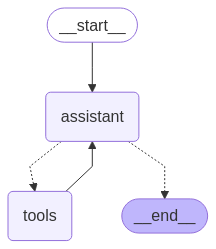

In [15]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph
builder = StateGraph(MessagesState)

# Define nodes
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # if the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # if the latest message (result) from assistant is not a tool call -> tools_condition routes to end
    tools_condition,
)

builder.add_edge("tools", "assistant")
react_graph = builder.compile()

# Show
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

In [16]:
# messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2, then divide the result by 5")]
messages = [HumanMessage(content="Mutiply the year Alber Einstein was born by 2. Then add the year he died.")]
messages = react_graph.invoke({"messages": messages})

In [17]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Mutiply the year Alber Einstein was born by 2. Then add the year he died.
================================== Ai Message ==================================
Tool Calls:
  search_online (027738e7-c91c-4fdc-ae8a-316c7e249331)
 Call ID: 027738e7-c91c-4fdc-ae8a-316c7e249331
  Args:
    query: year Albert Einstein was born
  search_online (3b81af99-5b13-48ea-828f-f110832e8290)
 Call ID: 3b81af99-5b13-48ea-828f-f110832e8290
  Args:
    query: year Albert Einstein died
================================= Tool Message =================================
Name: search_online

Albert Einstein[a] (14 March 1879 – 18 April 1955) was a German-born theoretical physicist who is best known for developing the theory of relativity. Einstein also made important contributions to quantum mechanics.[1][5] His mass–energy equivalence formula E = _mc_2, which arises from special relativity, has been called "the world's most famous equa

#### **LangSmith**

LangSmith give us tracing.

Ensure these enviroment variables are set:

    export LANGCHAIN_API_KEY="XXX"
    export LANGCHAIN_ENDPOINT="https://api.smith.langchain.com"
    export LANGCHAIN_TRACING_V2=true

And then set our `LANGCHAIN_PROJECT`.